In [ ]:
from torch import nn
import torch
import argparse
import numpy as np
import os

from modules import network,mlp
from modules.memory_bank import StaticMemoryBank_for_MSLOSS
from modules.multi_similarity_loss import MultiSimilarityLoss_Boost
from utils import yaml_config_hook,save_model,data_preocess
from evaluation import  evaluation_tools
import warnings
warnings.filterwarnings("ignore")

In [ ]:
parser = argparse.ArgumentParser()
config = yaml_config_hook("config/config.yaml")
for k, v in config.items():
    parser.add_argument(f"--{k}", default=v, type=type(v))
args = parser.parse_args([])
if not os.path.exists(args.model_path):
    os.makedirs(args.model_path)

class_num = args.classnum

In [ ]:
x_ndarray,y_ndarray=data_preocess.data_process(x_path='data/HCF-spleen_filtered_Counts.npz',y_path='data/HCF-spleen_annoData.txt',args=args)

X Shape: (13180, 2000), Y Shape: (13180, 1)


In [ ]:
print(np.unique(y_ndarray))

[1 2 3 4 5 6 7 8 9]


In [ ]:
from torch.utils.data import DataLoader,TensorDataset
scDataset = TensorDataset(torch.tensor(x_ndarray, dtype=torch.float32))

scDataLoader = DataLoader(scDataset, shuffle=True, batch_size=args.batch_size,drop_last=True)

for features in scDataLoader:
    print(len(features))
    print(len(features[0]))
    break

1
512


In [ ]:
mlpp=mlp.MLP()
model=network.Network(mlpp,feature_dim=args.feature_dim)
model.to('cuda')
optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)

In [ ]:
def train(ms_loss,memory_bank,model):
    loss_epoch=0
    for step,data in enumerate(scDataLoader):
        optimizer.zero_grad()
        
        data,pseudolabel=memory_bank.generate_data(data[0].numpy())
        data=torch.tensor(data,dtype=torch.float32).to('cuda')
        pseudolabel=torch.tensor(pseudolabel,dtype=torch.long).to('cuda')
        embedding=model(data)
        loss=ms_loss(embedding,pseudolabel)
        loss.backward()
        optimizer.step()
        loss_epoch+=loss.item()
        if step % 5 == 0:
                print(f"Step [{step}/{len(scDataLoader)}]\t loss:{loss.item()}")
            
    return loss_epoch

In [ ]:
def validation(model,x_ndarray,y_ndarray,epoch):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    with torch.no_grad():
        x=torch.tensor(x_ndarray,dtype=torch.float32).to(device)
        embeddings=model.forward_embedding(x)
        embeddings=embeddings.detach().cpu().numpy()
        results=evaluation_tools.cluster_embedding(embedding=embeddings,cluster_methods=['KMeans','Leiden'],cluster_number=args.classnum,cosine=False,Y=y_ndarray.squeeze(),save_pred=True)
        print(f'Epoch {epoch} with KMeans predict label\n' + f"ARI:{round(results['kmeans_ari'], 2)}  " + f"NMI:{round(float(results['kmeans_nmi']), 2)} \n")
        print(f'Epoch {epoch} with Leiden predict label\n' + f"ARI:{round(results['leiden_ari'], 2)}  " + f"NMI:{round(float(results['leiden_nmi']), 2)} \n")
        return results['kmeans_ari'],results['kmeans_nmi']


In [ ]:
loss_device=torch.device('cuda')
memory_bank=StaticMemoryBank_for_MSLOSS(args.batch_size,x_ndarray,args.num_genes,args.NN_COUNT,max_elements=args.MAX_ELEMENTS)
ms_loss=MultiSimilarityLoss_Boost(args=args)
losses=[]
aris=[]
nmis=[]


for epoch in range(args.start_epoch, args.epochs+1):
    lr = optimizer.param_groups[0]["lr"]
    loss_epoch = train(ms_loss,memory_bank,model)
    losses.append(loss_epoch/len(scDataLoader))
    if epoch % 10 == 0:
        save_model(args, model, optimizer, epoch)
        ari,nmi = validation(model,x_ndarray,y_ndarray,epoch)
        aris.append(ari)
        nmis.append(nmi)
    print(f"\nEpoch [{epoch}/{args.epochs}]\t Loss: {loss_epoch / len(scDataLoader)} \n")


Step [0/25]	 loss:7.129368305206299
Step [5/25]	 loss:7.12830924987793
Step [10/25]	 loss:7.1252336502075195
Step [15/25]	 loss:7.119016647338867
Step [20/25]	 loss:7.109424114227295

Epoch [1/300]	 Loss: 7.119973678588867 

Step [0/25]	 loss:7.094735145568848
Step [5/25]	 loss:7.079390525817871
Step [10/25]	 loss:7.061126232147217
Step [15/25]	 loss:7.044458389282227
Step [20/25]	 loss:7.032142162322998

Epoch [2/300]	 Loss: 7.056475582122803 

Step [0/25]	 loss:7.019571304321289
Step [5/25]	 loss:7.016355514526367
Step [10/25]	 loss:7.0098876953125
Step [15/25]	 loss:7.010295867919922
Step [20/25]	 loss:7.006547927856445

Epoch [3/300]	 Loss: 7.010062046051026 

Step [0/25]	 loss:6.998675346374512
Step [5/25]	 loss:7.006986618041992
Step [10/25]	 loss:6.992351531982422
Step [15/25]	 loss:6.998315334320068
Step [20/25]	 loss:6.989874839782715

Epoch [4/300]	 Loss: 6.995497570037842 

Step [0/25]	 loss:6.98825216293335
Step [5/25]	 loss:6.989425182342529
Step [10/25]	 loss:6.9828448295

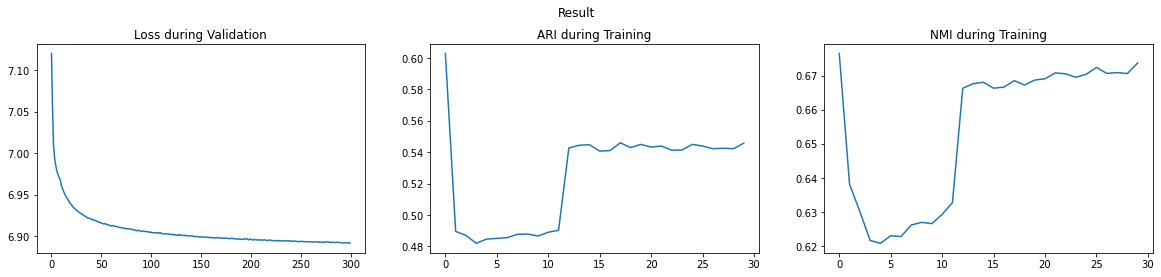

In [ ]:
from matplotlib import pyplot as plt

f, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 4))
ax[0].plot(losses)
ax[0].set_title('Loss during Validation')
ax[1].plot(aris)
ax[1].set_title('ARI during Training')
ax[2].plot(nmis)
ax[2].set_title('NMI during Training')

plt.subplots_adjust(top=0.85)
plt.suptitle('Result')
plt.show()

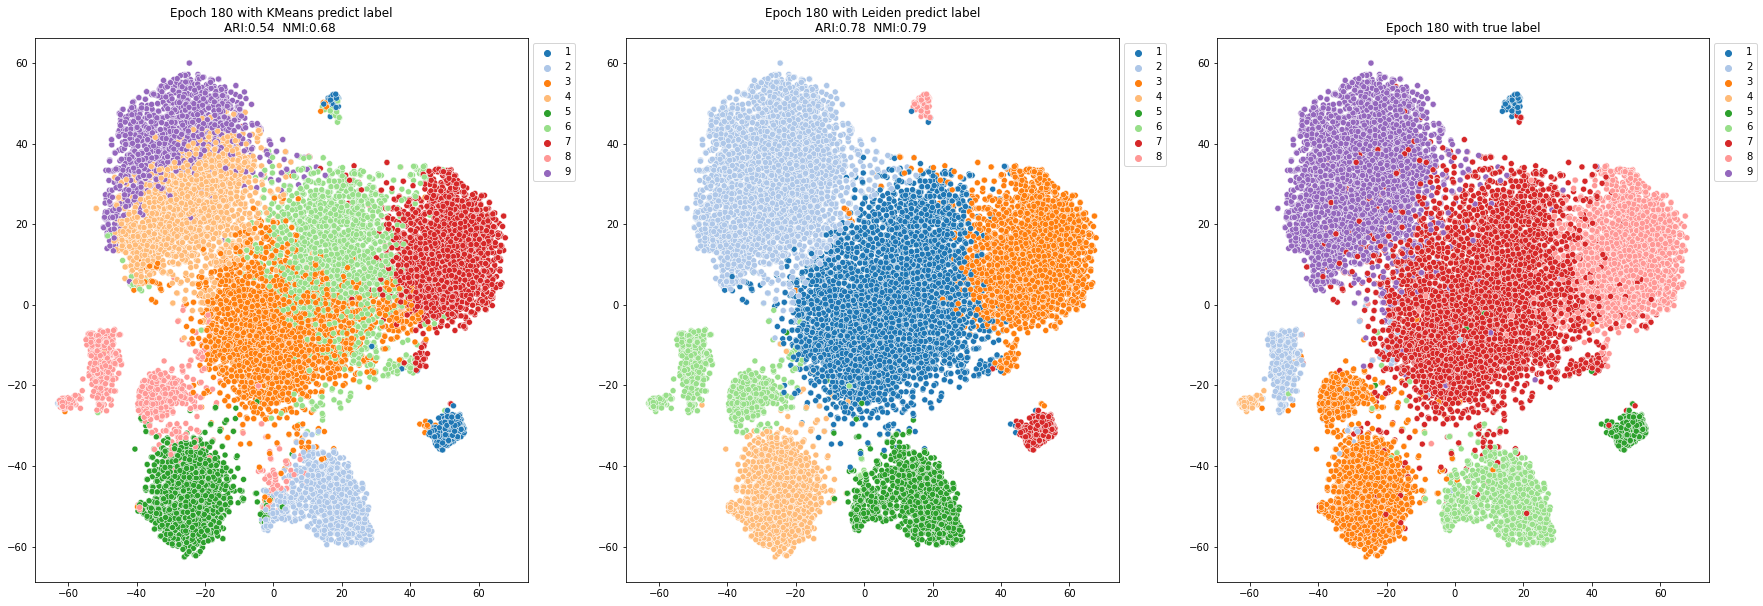

In [ ]:
mlp_1 = mlp.MLP(num_genes=args.num_genes)
model = network.Network(mlp_1, args.feature_dim)
model = model.to('cuda')

checkpoint = torch.load('save\sc-ms-loss-HCF\checkpoint_300.tar')
model.load_state_dict(checkpoint['net'])

x=torch.tensor(x_ndarray,dtype=torch.float32).to('cuda')
embeddings=model.forward_embedding(x)
embeddings=embeddings.detach().cpu().numpy()
results=evaluation_tools.cluster_embedding(embedding=embeddings,cluster_methods=['KMeans','Leiden'],cluster_number=args.classnum,cosine=False,Y=y_ndarray.squeeze(),save_pred=True)
evaluation_tools.embedding_cluster_visualization(embeddings=embeddings,result=results,true_label=y_ndarray.squeeze(),args=args,epoch=180)

In [ ]:
mlp_1 = mlp.MLP(num_genes=args.num_genes)
model = network.Network(mlp_1, args.feature_dim)
model = model.to('cuda')

checkpoint = torch.load('save\sc-ms-loss-thresh05-margin0-50\checkpoint_30.tar')
model.load_state_dict(checkpoint['net'])

x=torch.tensor(x_ndarray,dtype=torch.float32).to('cuda')
embeddings=model.forward_embedding(x)
embeddings=embeddings.detach().cpu().numpy()
results=evaluation_tools.cluster_embedding(embedding=embeddings,cluster_methods=['KMeans','Leiden'],cluster_number=args.classnum,cosine=False,Y=y_ndarray.squeeze(),save_pred=True)
evaluation_tools.embedding_cluster_visualization(embeddings=embeddings,result=results,true_label=y_ndarray.squeeze(),args=args,epoch=180)

FileNotFoundError: [Errno 2] No such file or directory: 'save\\sc-ms-loss-thresh05-margin0-50\\checkpoint_30.tar'

In [ ]:
mlp_1 = mlp.MLP(num_genes=args.num_genes)
model = network.Network(mlp_1, args.feature_dim)
model = model.to('cuda')

checkpoint = torch.load('save\sc-ms-loss\checkpoint_120.tar')
model.load_state_dict(checkpoint['net'])

x=torch.tensor(x_ndarray,dtype=torch.float32).to('cuda')
embeddings=model.forward_embedding(x)
embeddings=embeddings.detach().cpu().numpy()
results=evaluation_tools.cluster_embedding(embedding=embeddings,cluster_methods=['KMeans','Leiden'],cluster_number=args.classnum,cosine=False,Y=y_ndarray.squeeze(),save_pred=True)
evaluation_tools.embedding_cluster_visualization(embeddings=embeddings,result=results,true_label=y_ndarray.squeeze(),args=args,epoch=120)

In [ ]:
mlp_1 = mlp.MLP(num_genes=args.num_genes)
model = network.Network(mlp_1, args.feature_dim)
model = model.to('cuda')

checkpoint = torch.load('save\sc-ms-loss\checkpoint_60.tar')
model.load_state_dict(checkpoint['net'])

x=torch.tensor(x_ndarray,dtype=torch.float32).to('cuda')
embeddings=model.forward_embedding(x)
embeddings=embeddings.detach().cpu().numpy()
results=evaluation_tools.cluster_embedding(embedding=embeddings,cluster_methods=['KMeans','Leiden'],cluster_number=args.classnum,cosine=False,Y=y_ndarray.squeeze(),save_pred=True)
evaluation_tools.embedding_cluster_visualization(embeddings=embeddings,result=results,true_label=y_ndarray.squeeze(),args=args,epoch=60)

In [ ]:
mlp_1 = mlp.MLP(num_genes=args.num_genes)
model = network.Network(mlp_1, args.feature_dim)
model = model.to('cuda')

checkpoint = torch.load('save\sc-ms-loss\checkpoint_15.tar')
model.load_state_dict(checkpoint['net'])

x=torch.tensor(x_ndarray,dtype=torch.float32).to('cuda')
embeddings=model.forward_embedding(x)
embeddings=embeddings.detach().cpu().numpy()
results=evaluation_tools.cluster_embedding(embedding=embeddings,cluster_methods=['KMeans','Leiden'],cluster_number=args.classnum,cosine=False,Y=y_ndarray.squeeze(),save_pred=True)
evaluation_tools.embedding_cluster_visualization(embeddings=embeddings,result=results,true_label=y_ndarray.squeeze(),args=args,epoch=30)

In [ ]:
mlp_1 = mlp.MLP(num_genes=args.num_genes)
model = network.Network(mlp_1, args.feature_dim)
model = model.to('cuda')

checkpoint = torch.load('save\sc-ms-loss\checkpoint_240.tar')
model.load_state_dict(checkpoint['net'])

x=torch.tensor(x_ndarray,dtype=torch.float32).to('cuda')
embeddings=model.forward_embedding(x)
embeddings=embeddings.detach().cpu().numpy()
results=evaluation_tools.cluster_embedding(embedding=embeddings,cluster_methods=['KMeans','Leiden'],cluster_number=args.classnum,cosine=False,Y=y_ndarray.squeeze(),save_pred=True)
evaluation_tools.embedding_cluster_visualization(embeddings=embeddings,result=results,true_label=y_ndarray.squeeze(),args=args,epoch=240)

In [ ]:
mlp_1 = mlp.MLP(num_genes=args.num_genes)
model = network.Network(mlp_1, args.feature_dim)
model = model.to('cuda')

checkpoint = torch.load('save\sc-ms-loss\checkpoint_300.tar')
model.load_state_dict(checkpoint['net'])

x=torch.tensor(x_ndarray,dtype=torch.float32).to('cuda')
embeddings=model.forward_embedding(x)
embeddings=embeddings.detach().cpu().numpy()
results=evaluation_tools.cluster_embedding(embedding=embeddings,cluster_methods=['KMeans','Leiden'],cluster_number=args.classnum,cosine=False,Y=y_ndarray.squeeze(),save_pred=True)
evaluation_tools.embedding_cluster_visualization(embeddings=embeddings,result=results,true_label=y_ndarray.squeeze(),args=args,epoch=300)

In [ ]:
mlp_1 = mlp.MLP(num_genes=args.num_genes)
model = network.Network(mlp_1, args.feature_dim)
model = model.to('cuda')

checkpoint = torch.load('save\sc-ms-loss\checkpoint_300.tar')
model.load_state_dict(checkpoint['net'])

x=torch.tensor(x_ndarray,dtype=torch.float32).to('cuda')
embeddings=model.forward_embedding(x)
embeddings=embeddings.detach().cpu().numpy()
results=evaluation_tools.cluster_embedding(embedding=embeddings,cluster_methods=['KMeans','Leiden'],cluster_number=args.classnum,cosine=False,Y=y_ndarray.squeeze(),save_pred=False)
# evaluation_tools.embedding_cluster_visualization(embeddings=embeddings,result=results,true_label=y_ndarray.squeeze(),args=args,epoch=286)
print(results)